# Basic recommender


In this tutorial, we build a simple matrix factorization model using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/) with TFRS. We can use this model to recommend movies for a given user.

### Import TFRS

First, install and import TFRS:

In [1]:
from typing import Dict, Text
import os
import pprint
import tempfile
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

C:\Users\William\AppData\Local\Temp\ipykernel_16088\1842447031.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


### Chargement des données

In [8]:
# Chargement des données users
users = pd.read_csv('data/output/users.csv', sep=',')

In [9]:
# Chargement des données de films
items = pd.read_csv('data/output/items.csv',sep=',',encoding='latin-1')

In [10]:
# Chargement des notes
ratings= pd.read_csv('data/output/ratings.csv',sep=',')

### Exploration des données

#### Analyse des données des utilisateurs

In [14]:
# Détermination du nombre d'utilisateurs
print("Nombre d'utilisateurs : ",users.shape[0])

Nombre d'utilisateurs :  943


In [15]:
# Affichage de 20 exemples d'utilisateurs
users.head(20)

,user_id,age,sex,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
5,6,42,M,executive,98101
6,7,57,M,administrator,91344
7,8,36,M,administrator,05201
8,9,29,M,student,01002
9,10,53,M,lawyer,90703


On remarque que les utilisateurs sont caractérisés par leur âge, leur sexe, leur occupation et leur code postal. Essayons de faire quelques statistiques sur ces variables.

In [17]:
# Affichage des colonnes
print("Les variables des utilisateurs sont :",list(users.columns))

Les variables des utilisateurs sont : ['user_id', 'age', 'sex', 'occupation', 'zipcode']


In [18]:
# 
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   sex         943 non-null    object
 3   occupation  943 non-null    object
 4   zipcode     943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB
None


On remarque qu'aucune des variables n'a de valeurs nulles. On peut dire que les données sont complètes. Hormis l'âge, toutes les autres variables caractéristiques sont qualitatives. Etablissons un profil d'utilisateur par caractérisation de ces données.

Axes(0.125,0.11;0.775x0.77)


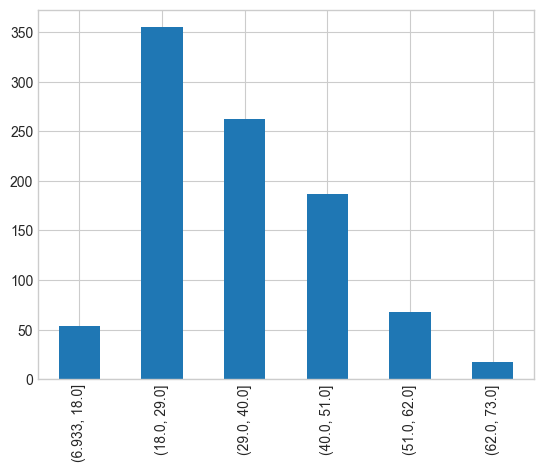

In [35]:
#Variables quantitatives (âge uniquement)
print(users['age'].value_counts(bins=6,sort=True).sort_index().plot(kind='bar'))

On peut remarquer que la plupart des utilisateurs ont entre 18 et 29 ans. Le troisième âge est moins représenté dans ce jeu.

Axes(0.125,0.11;0.775x0.77)


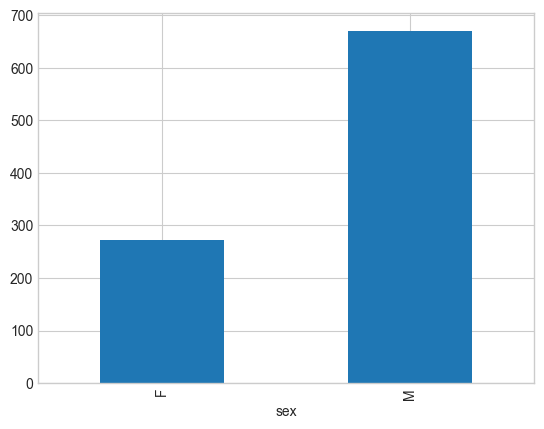

In [37]:
# Variables qualitatives (sexe)
print(users['sex'].value_counts().sort_index().plot(kind='bar'))

On peut remarquer que les hommes sont les plus représentés dans cet échantillon de données

Axes(0.125,0.11;0.775x0.77)


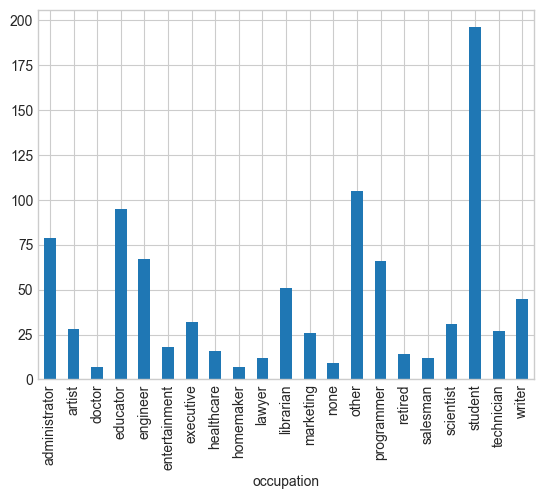

In [38]:
#Variables qualitatives (occupation)
print(users['occupation'].value_counts().sort_index().plot(kind='bar'))

On peut remarquer que les étudiants sont les plus représentés dans l'échantillon de données. Les doctors et les personnes ménagères sont les catégories les plus faiblement dénombrées.

#### Analyse des données de films

#### Analyse des notes attribuées aux films par les utilisateurs

In [ ]:
ratings_full = tfds.load('movielens/100k-ratings', split="train")

user_ids = ratings_full.map(lambda x: x["user_id"])
unique_user_ids = np.unique(list(tfds.as_numpy(user_ids)))

movie_titles = ratings_full.map(lambda x: x["movie_title"])
unique_movie_titles = np.unique(list(tfds.as_numpy(movie_titles)))

> ### TODO
>
> Display the ten first examples to explore the list of available informations
>
> Usefull: `Dataset.take(count)`, `tfds.as_numpy()`, `tfds.as_dataframe()`


In [ ]:
print(unique_user_ids.size)
print(unique_movie_titles.size)
print(ratings_full.cardinality().numpy()/(unique_user_ids.size*unique_movie_titles.size))

# TODO here
tfds.as_dataframe(ratings_full.take(10))

Restrict the dataset to used features.

In [ ]:
# Ratings data.
ratings = ratings_full.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "timestamp": x["timestamp"],
})
tfds.as_dataframe(ratings.take(10))


Split the data into a training set and a testing set.

In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

### Define a model

We can define a prediction model by inheriting from `tf.keras.Model` and implementing the `call` method.

> ### TODO
>
> Draw the model

In [ ]:
class DotRankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.layers.Dot(axes=(1))

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embedding = self.user_embeddings(features["user_id"])
    movie_embedding = self.movie_embeddings(features["movie_title"])

    return self.ratings((user_embedding, movie_embedding))

In [ ]:
DotRankingModel()({"user_id": ["42","42"], "movie_title":["One Flew Over the Cuckoo's Nest (1975)", "Strictly Ballroom (1992)"]})

We can define a TFRS model by inheriting from `tfrs.Model` and implementing the `compute_loss` method.

> ### TODO
>
> Explain the role played by this model

In [ ]:
class MovieLensModel(tfrs.models.Model):

  def __init__(self, rating_model: tf.keras.Model):
    super().__init__()
    self.ranking_model = rating_model
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(features)

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("user_rating")

    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

## Fit and test the model

In [ ]:
# Create a retrieval model.
model = MovieLensModel(DotRankingModel())
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
dot_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=10,
    verbose=1)

test_accuracy = dot_model_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

In [ ]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

> ### TODO
>
> Comment the curve

# More complex link between user's and item's representations

Let replace the dot product between user's and item's representations by a fully connected layer of size 64, followed by a fully connected layer with a unique output.

> ### TODO
>
> - Define the layer and adapt the `call` method
> - Choose carefully the activation functions of the layers
>
> USefull: `tf.keras.Sequential`, `tf.keras.Dense`, `tf.concat`

In [ ]:
class OneLayerRankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)])

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embedding = self.user_embeddings(features["user_id"])
    movie_embedding = self.movie_embeddings(features["movie_title"])

    return self.ratings(tf.concat((user_embedding,movie_embedding),axis=1))

In [ ]:
OneLayerRankingModel()({"user_id": ["42"], "movie_title":["One Flew Over the Cuckoo's Nest (1975)"]})

In [ ]:
# Create a retrieval model.
model = MovieLensModel(OneLayerRankingModel())
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
one_layer_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=10,
    verbose=1)

test_accuracy = one_layer_model_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

In [ ]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

# Taking advantage of context features

Let use timestamps of the ratings and movie titles to enrich the input of the model.

Some preliminary:

In [ ]:
timestamps = np.concatenate(list(ratings_full.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

New user model.

> ### TODO
>
> Draw and explain the role played by the components of the model

In [ ]:
class EnrichedRankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Building blocks to compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    self.timestamp_embeddings = tf.keras.Sequential([
        tf.keras.layers.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, embedding_dimension),
    ])

    self.normalized_timestamp = tf.keras.layers.Normalization(
        axis=None
    )
    self.normalized_timestamp.adapt(timestamps)

    # Building blocks to compute embeddings for movies.
    max_tokens = 10_000

    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
      max_tokens=max_tokens)

    self.title_text_embeddings = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(unique_movie_titles)



    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
    ])

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embedding = tf.concat([
        self.user_embeddings(features["user_id"]),
        self.timestamp_embeddings(features["timestamp"]),
        tf.reshape(self.normalized_timestamp(features["timestamp"]), (-1, 1)),
    ], axis=1)

    movie_embedding = tf.concat([
        self.movie_embeddings(features["movie_title"]),
        self.title_text_embeddings(features["movie_title"]),
    ], axis=1)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [ ]:
EnrichedRankingModel()({"user_id": ["42"], "movie_title":["One Flew Over the Cuckoo's Nest (1975)"], "timestamp":[879024327]})

In [ ]:
# Create a retrieval model.
model = MovieLensModel(EnrichedRankingModel())
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
enriched_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=10,
    verbose=1)

test_accuracy = enriched_model_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

In [ ]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.plot(enriched_model_history.history["val_root_mean_squared_error"], label="enriched")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

# More comple models



> ### TODO
>
> Build and test more complex models:
> - with more layers to link user's and item's representation
> - integrating more contextual information: user's age, movie's genre, ...



# Copyright

Several section of this notebook originate from notebooks under the following copyright:

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.